In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import os
import cv2
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Input data files are available in the read-only "../input/" directory
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d carlolepelaars/camvid

100% 575M/575M [00:20<00:00, 31.1MB/s]
100% 575M/575M [00:20<00:00, 29.1MB/s]


In [4]:
! unzip camvid.zip

Archive:  camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_007290.pn

In [5]:
colors = pd.read_csv('/content/CamVid/class_dict.csv').set_index("name")
classes = {cl:list(colors.loc[cl, :]) for cl in colors.index}
classes

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'SUVPickupTruck': [64, 128, 192],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [6]:
for i in list(classes.values()): 
    print(i)

[64, 128, 64]
[192, 0, 128]
[0, 128, 192]
[0, 128, 64]
[128, 0, 0]
[64, 0, 128]
[64, 0, 192]
[192, 128, 64]
[192, 192, 128]
[64, 64, 128]
[128, 0, 192]
[192, 0, 64]
[128, 128, 64]
[192, 0, 192]
[128, 64, 64]
[64, 192, 128]
[64, 64, 0]
[128, 64, 128]
[128, 128, 192]
[0, 0, 192]
[192, 128, 128]
[128, 128, 128]
[64, 128, 192]
[0, 0, 64]
[0, 64, 64]
[192, 64, 128]
[128, 128, 0]
[192, 128, 192]
[64, 0, 64]
[192, 192, 0]
[0, 0, 0]
[64, 192, 0]


In [7]:
def load_masks(main_path):
    mask = tf.io.read_file(main_path)
    mask = tf.image.decode_png(mask, channels=3)

    # Resize image and mask
    mask = tf.image.resize(mask, size=(128, 128))

    # Convert image and mask to float32 and normalize pixel values
    mask = mask_preprocess(mask)
    return mask

In [8]:
def load_images(main_path):
    image = tf.io.read_file(main_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize image and mask
    image = tf.image.resize(image, size=(128, 128))

    # Convert image and mask to float32 and normalize pixel values
    image = tf.cast(image , tf.float32) / 255
    return image

In [9]:
def mask_preprocess(mask):
    chann = []
    for i in list(classes.values()):
        equali = np.equal(mask , i)
        maski = np.all(equali , axis = -1)
        chann.append(maski)
    chann = np.stack(chann , axis = -1)
    return np.float32(chann)

In [10]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, images_dir, masks_dir, batch_size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
      

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))


    def __getitem__(self, idx):
        batch_image_filenames = self.image_filenames[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask_filenames = self.mask_filenames[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images = []
        batch_masks = []
        for image_filename, mask_filename in zip(batch_image_filenames, batch_mask_filenames):
            image_path = os.path.join(self.images_dir, image_filename)
            mask_path = os.path.join(self.masks_dir, mask_filename)
            image = load_images(image_path) # replace with your image loading function
            mask_32_channels = load_masks(mask_path) # apply your function
            batch_images.append(image)
            batch_masks.append(mask_32_channels)
        return np.array(batch_images), np.array(batch_masks)



In [11]:
generator = CustomDataGenerator(images_dir='/content/CamVid/train', masks_dir='/content/CamVid/train_labels', batch_size=30)
val_generator = CustomDataGenerator(images_dir='/content/CamVid/val', masks_dir='/content/CamVid/val_labels', batch_size=30)

In [12]:
def conv_block(tensor, nfilters, size=2, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 32):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [13]:
x,y = val_generator.__getitem__(1)
print(x.shape, y.shape)

(30, 128, 128, 3) (30, 128, 128, 32)


Images


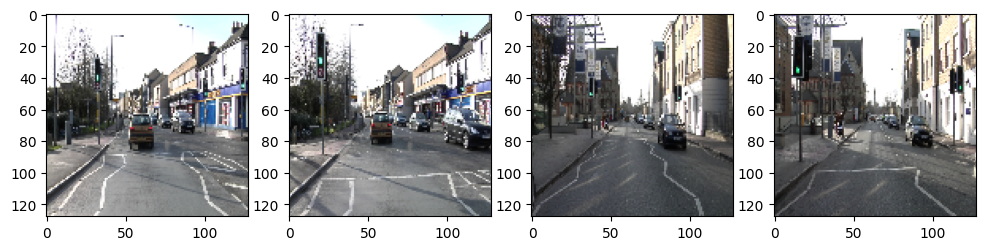

Masks


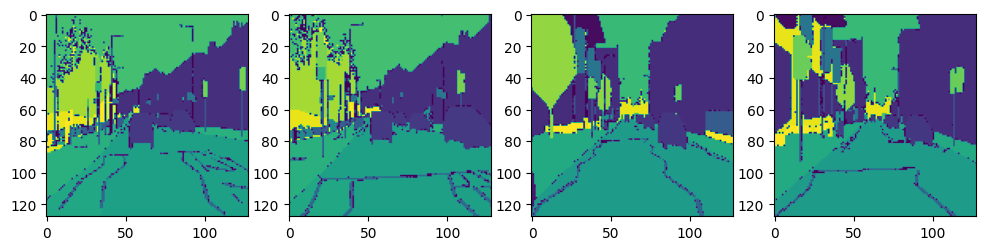

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
print("Images")
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i])
plt.show()

print("Masks")
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.argmax(y[i] , axis = -1))
plt.show()

In [15]:
model = Unet(128 , 128 , 64)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [17]:
model.fit(generator, steps_per_epoch=len(generator), epochs=50 , validation_data = val_generator)

Epoch 1/50
13/13 [==============================] - 71s 3s/step - loss: 2.5992 - accuracy: 0.3425 - val_loss: 3.4609 - val_accuracy: 0.1377
Epoch 2/50
13/13 [==============================] - 37s 3s/step - loss: 1.6230 - accuracy: 0.6118 - val_loss: 14.7971 - val_accuracy: 0.2811
Epoch 3/50
13/13 [==============================] - 36s 3s/step - loss: 1.3350 - accuracy: 0.6335 - val_loss: 17.5621 - val_accuracy: 0.3592
Epoch 4/50
13/13 [==============================] - 32s 2s/step - loss: 1.1804 - accuracy: 0.6540 - val_loss: 7.3399 - val_accuracy: 0.3578
Epoch 5/50
13/13 [==============================] - 32s 2s/step - loss: 1.0761 - accuracy: 0.6769 - val_loss: 4.6216 - val_accuracy: 0.4996
Epoch 6/50
13/13 [==============================] - 37s 3s/step - loss: 1.0391 - accuracy: 0.6797 - val_loss: 3.6023 - val_accuracy: 0.3849
Epoch 7/50
13/13 [==============================] - 33s 3s/step - loss: 0.9893 - accuracy: 0.6950 - val_loss: 2.9561 - val_accuracy: 0.4843
Epoch 8/50
13/13 [

In [22]:
a = model.fit(generator, steps_per_epoch=len(generator), epochs=20 , validation_data = val_generator)

Epoch 1/20
13/13 [==============================] - 34s 3s/step - loss: 0.4965 - accuracy: 0.8283 - val_loss: 0.8596 - val_accuracy: 0.7281
Epoch 2/20
13/13 [==============================] - 32s 3s/step - loss: 0.4950 - accuracy: 0.8287 - val_loss: 0.7653 - val_accuracy: 0.7427
Epoch 3/20
13/13 [==============================] - 32s 2s/step - loss: 0.4828 - accuracy: 0.8328 - val_loss: 0.7125 - val_accuracy: 0.7705
Epoch 4/20
13/13 [==============================] - 33s 3s/step - loss: 0.5038 - accuracy: 0.8254 - val_loss: 0.9463 - val_accuracy: 0.7084
Epoch 5/20
13/13 [==============================] - 37s 3s/step - loss: 0.5250 - accuracy: 0.8189 - val_loss: 0.8527 - val_accuracy: 0.7316
Epoch 6/20
13/13 [==============================] - 37s 3s/step - loss: 0.5531 - accuracy: 0.8110 - val_loss: 0.7214 - val_accuracy: 0.7654
Epoch 7/20
13/13 [==============================] - 37s 3s/step - loss: 0.5139 - accuracy: 0.8224 - val_loss: 0.9366 - val_accuracy: 0.7067
Epoch 8/20
13/13 [==

In [30]:
a = load_images('/content/CamVid/test/Seq05VD_f02610.png')

In [31]:
a = np.expand_dims(a , axis = 0)
c = model.predict(a)

1/1 [==============================] - 0s 22ms/step


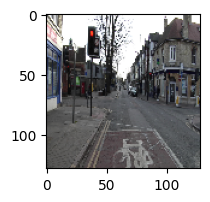

In [32]:
plt.figure(figsize = (10 , 2))
plt.imshow(np.squeeze(a))

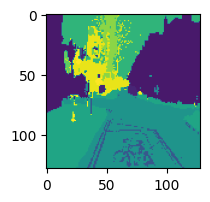

In [33]:
plt.figure(figsize = (10,2))
plt.imshow(np.squeeze(np.argmax(c , axis = -1)))